In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from datetime import datetime
import numpy as np
import mysql.connector

db = mysql.connector.connect(host = "localhost",
                             user = "root",
                             password = "Nivetha-arunjp",
                             database = "ecommerce")

cur = db.cursor()

# 1. List unique cities where customers are located.

In [190]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Customer_City'])
df.head()

,Customer_City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2. Count the number of orders placed in 2017.

In [192]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017  """

cur.execute(query)

data = cur.fetchall()
"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 45101)

# 3. Find the total sales per category.

In [92]:
query = """ WITH distinct_order_items AS (
    SELECT DISTINCT order_id, product_id, price
    FROM order_items
),
distinct_payments AS (
    SELECT DISTINCT order_id, payment_value
    FROM payments
),
item_payment_combined AS (
    SELECT doi.product_id, dp.payment_value
    FROM distinct_order_items doi
    JOIN distinct_payments dp ON doi.order_id = dp.order_id
)

SELECT 
    p.product_category AS category,
    ROUND(SUM(ipc.payment_value), 2) AS total_sales
FROM item_payment_combined ipc
JOIN products p ON ipc.product_id = p.product_id
GROUP BY p.product_category """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Category', 'Sales'])
df

,Category,Sales
0,telephony,406549.62
1,bed table bath,1453936.81
2,computer accessories,1146724.92
3,Furniture Decoration,1021687.60
4,perfumery,469457.76
...,...,...
69,cds music dvds,954.99
70,La Cuisine,2579.41
71,Fashion Children's Clothing,785.67
72,PC Gamer,1717.05


# 4. Calculate the percentage of orders that were paid in installments.

In [52]:
query = """ select (sum(payment_installments >=1))/count(*)*100 from payments """
cur.execute(query)

data = cur.fetchall()
"the percentage of orders that were paid in installments is", data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# 5. Count the number of customers from each state.

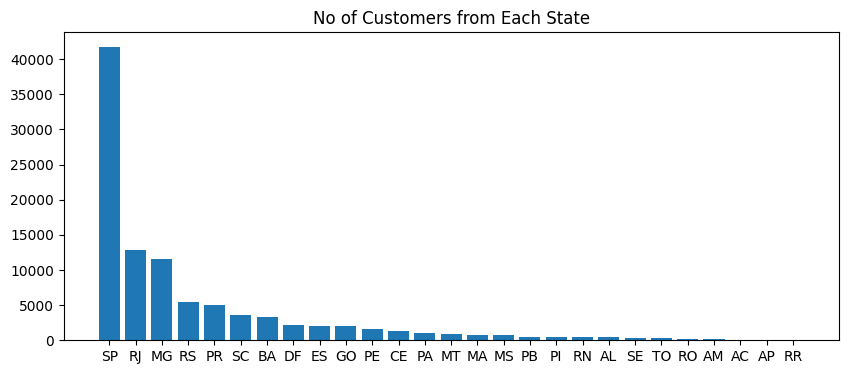

In [113]:
query = """ select customer_state, count(customer_id)
from customers
group by customer_state """
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=['State','Customer_Count'])
df = df.sort_values(by = 'Customer_Count', ascending = False)
plt.figure(figsize=(10,4))
plt.bar(df['State'], df['Customer_Count'])
plt.title("No of Customers from Each State")
plt.show()

# 6. Calculate the number of orders per month in 2018.

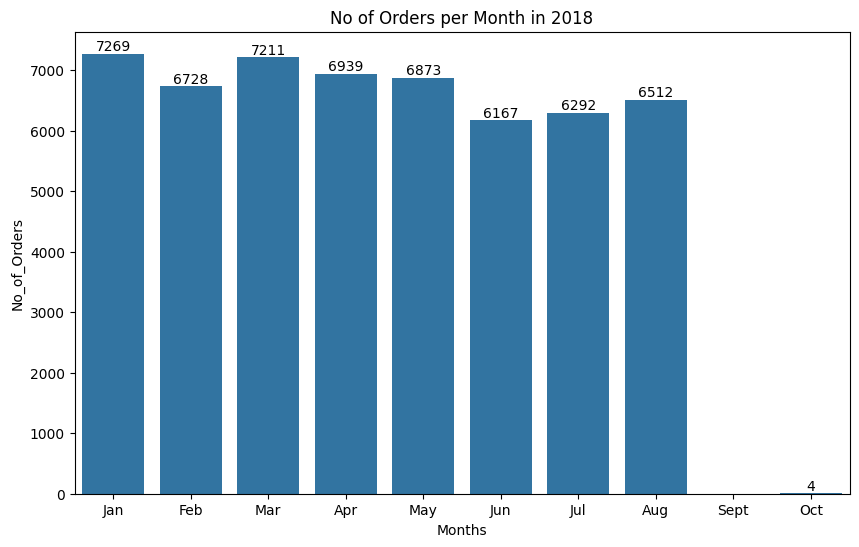

In [135]:
query = """ select monthname(order_purchase_timestamp), count(order_id)
from orders where order_purchase_timestamp = 2018
group by monthname(order_purchase_timestamp)"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Months','No_of_Orders'])
df['Months'] = df['Months'].apply(lambda x: datetime.strptime(x, '%B').strftime('%b'))

month_order= ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct']

plt.figure(figsize=(10,6))
ax = sns.barplot(x = df["Months"], y = df["No_of_Orders"], data = df, order = month_order)
ax.bar_label(ax.containers[0])
plt.title("No of Orders per Month in 2018")
plt.show()

# 7. Find the average number of products per order, grouped by customer city.

In [71]:
query = """WITH distinct_order_items AS (
    SELECT DISTINCT order_id, product_id
    FROM order_items
),
product_count_per_order AS (
    SELECT order_id, COUNT(product_id) AS product_count
    FROM distinct_order_items
    GROUP BY order_id
),
order_customer_city AS (
    SELECT o.order_id, c.customer_city
    FROM orders o
    JOIN customers c ON o.customer_id = c.customer_id
)

SELECT 
    occ.customer_city,
    ROUND(AVG(pco.product_count), 2) AS avg_products_per_order
FROM product_count_per_order pco
JOIN order_customer_city occ ON pco.order_id = occ.order_id
GROUP BY occ.customer_city
ORDER BY avg_products_per_order DESC """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Customer_City', 'Average_Orders'])
df.head(10)

,Customer_City,Average_Orders
0,padre carvalho,7.00
1,picarra,4.00
2,curralinho,4.00
3,teixeira soares,3.00
4,ipua,2.75
5,celso ramos,2.50
6,pauliceia,2.00
7,nova hartz,2.00
8,doutor ulysses,2.00
9,senador cortes,2.00


# 8. Calculate the percentage of total revenue contributed by each product category.

In [94]:
query = """ WITH distinct_order_items AS (
    SELECT DISTINCT order_id, product_id
    FROM order_items
),
distinct_payments AS (
    SELECT DISTINCT order_id, payment_value
    FROM payments
),
joined_data AS (
    SELECT doi.product_id, dp.payment_value
    FROM distinct_order_items doi
    JOIN distinct_payments dp ON doi.order_id = dp.order_id
),
category_sales AS (
    SELECT 
        p.product_category AS category,
        SUM(jd.payment_value) AS category_revenue
    FROM joined_data jd
    JOIN products p ON jd.product_id = p.product_id
    GROUP BY p.product_category
),
total_revenue AS (
    SELECT SUM(category_revenue) AS total FROM category_sales
)

SELECT 
    cs.category,
    ROUND((cs.category_revenue * 100.0 / tr.total), 2) AS revenue_percentage
FROM category_sales cs, total_revenue tr
ORDER BY revenue_percentage DESC;
 """ 



cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Category', 'Percentage Distribution'])
df.head(10)

,Category,Percentage Distribution
0,HEALTH BEAUTY,8.88
1,bed table bath,8.65
2,Watches present,8.03
3,sport leisure,7.15
4,computer accessories,6.82
5,Furniture Decoration,6.08
6,housewares,4.89
7,Cool Stuff,4.37
8,automotive,4.26
9,Garden tools,3.69


# 9. Identify the correlation between product price and the number of times a product has been purchased.

In [115]:
query = """ select p.product_category, count(distinct oi.product_id,oi.order_id), round(avg(oi.price),2)
from products p
join order_items oi on
p.product_id = oi.product_id
group by p.product_category order by p.product_category desc """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Category', 'Order Count', 'Price'])
df.head()

arr1 = df['Order Count']
arr2 = df['Price']

a = np.corrcoef([arr1,arr2])
print(" the correlation between the product price and the number of times a product purchased is", a[0][1])

 the correlation between the product price and the number of times a product purchased is -0.10448921163702476


# 10. Calculate the total revenue generated by each seller, and rank them by revenue.

In [145]:
query = """ WITH distinct_order_items AS (
    SELECT DISTINCT order_id, seller_id, product_id
    FROM order_items
),
distinct_payments AS (
    SELECT DISTINCT order_id, payment_value
    FROM payments
),
seller_revenue_data AS (
    SELECT doi.seller_id, dp.payment_value
    FROM distinct_order_items doi
    JOIN distinct_payments dp ON doi.order_id = dp.order_id
),
seller_revenue AS (
    SELECT 
        s.seller_id,
        SUM(srd.payment_value) AS total_revenue
    FROM seller_revenue_data srd
    JOIN sellers s ON srd.seller_id = s.seller_id
    GROUP BY s.seller_id
)

SELECT 
    seller_id,
    ROUND(total_revenue, 2) AS total_revenue,
    RANK() OVER (ORDER BY total_revenue DESC) AS revenue_rank
FROM seller_revenue
ORDER BY revenue_rank """

cur.execute(query)
data = cur.fetchall()
df = pd. DataFrame(data, columns = ['Seller_ID','Revenue','Rank'])
df.head()


,Seller_ID,Revenue,Rank
0,4a3ca9315b744ce9f8e9374361493884,271189.74,1
1,7c67e1448b00f6e969d365cea6b010ab,257388.49,2
2,4869f7a5dfa277a7dca6462dcf3b52b2,257263.34,3
3,53243585a1d6dc2643021fd1853d8905,234594.81,4
4,da8622b14eb17ae2831f4ac5b9dab84a,231693.69,5


# 11. Calculate the moving average of order values for each customer over their order history.

In [155]:
query = """ WITH distinct_orders AS (
    SELECT DISTINCT 
        o.customer_id, 
        o.order_id, 
        p.payment_value,
        o.order_purchase_timestamp
    FROM orders o
    JOIN payments p ON o.order_id = p.order_id
),
ordered_orders AS (
    SELECT 
        customer_id,
        order_id,
        payment_value,
        order_purchase_timestamp,
        ROW_NUMBER() OVER (PARTITION BY customer_id ORDER BY order_purchase_timestamp) AS order_num
    FROM distinct_orders
),
moving_avg AS (
    SELECT 
        customer_id,
        order_purchase_timestamp,
        payment_value,
        ROUND(AVG(payment_value) OVER (
            PARTITION BY customer_id 
            ORDER BY order_num
            ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
        ), 2) AS moving_avg_order_value
    FROM ordered_orders
)

SELECT * FROM moving_avg
ORDER BY customer_id """

cur.execute(query)
data = cur.fetchall()
df = pd. DataFrame(data, columns = ['Customer_ID','Order_Timestamp','Price','Moving Average'])
df

,Customer_ID,Order_Timestamp,Price,Moving Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.42
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.35
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.01
...,...,...,...,...
103266,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,0.64,27.12
103267,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.13
103268,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.13
103269,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.50


# 12. Calculate the cumulative sales per month for each year.

In [157]:
query = """ WITH monthly_sales AS (
    SELECT 
        YEAR(o.order_purchase_timestamp) AS order_year,
        MONTH(o.order_purchase_timestamp) AS order_month,
        SUM(DISTINCT p.payment_value) AS monthly_sales
    FROM orders o
    JOIN payments p ON o.order_id = p.order_id
    GROUP BY YEAR(o.order_purchase_timestamp), MONTH(o.order_purchase_timestamp)
),
cumulative_sales AS (
    SELECT 
        order_year,
        order_month,
        monthly_sales,
        SUM(monthly_sales) OVER (
            PARTITION BY order_year
            ORDER BY order_month
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS cumulative_sales
    FROM monthly_sales
)

SELECT 
    order_year,
    order_month,
    monthly_sales,
    ROUND(cumulative_sales, 2) AS cumulative_sales
FROM cumulative_sales
ORDER BY order_year, order_month """

cur.execute(query)
data = cur.fetchall()
df = pd. DataFrame(data, columns = ['Year','Month','Sales','Cumulative Sales'])
df

,Year,Month,Sales,Cumulative Sales
0,2016,9,252.239994,252.24
1,2016,10,55379.960037,55632.20
2,2016,12,19.620001,55651.82
3,2017,1,122628.520095,122628.52
4,2017,2,252840.189707,375468.71
5,2017,3,373576.479756,749045.19
6,2017,4,352872.829841,1101918.02
7,2017,5,484773.930227,1586691.95
8,2017,6,395519.030382,1982210.98
9,2017,7,434337.579863,2416548.56


# 13. Calculate the year-over-year growth rate of total sales.

In [161]:
query = """ with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id 
group by years order by years) 

select years, ((payment - lag(payment,1) over(order by years)) / 
               lag(payment, 1) over(order by years)) * 100 from a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years", "YoY % Growth"])
df

,Years,YoY % Growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# 14. Identify the top 3 customers who spent the most money in each year.

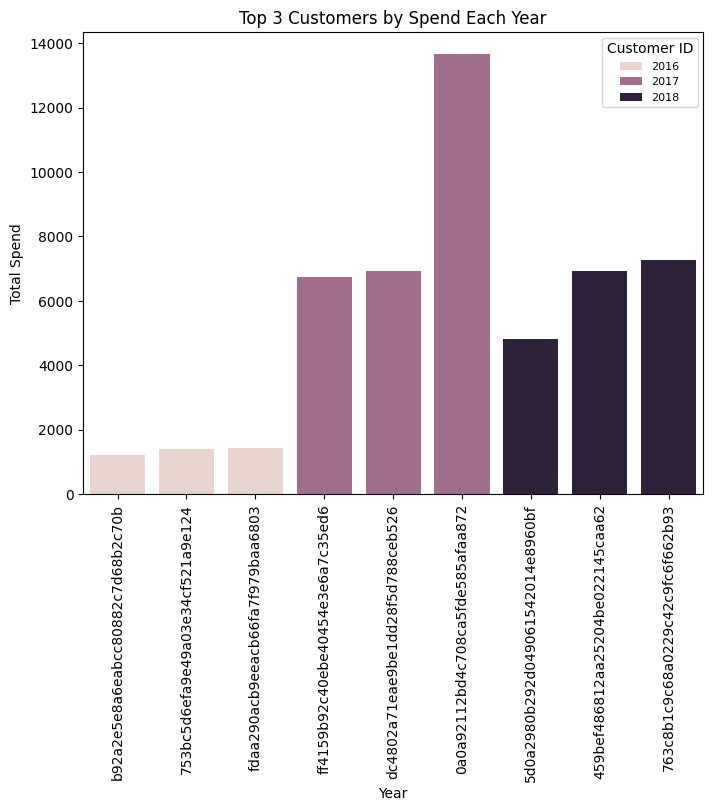

In [200]:
query = """ WITH customer_yearly_spend AS (
    SELECT 
        c.customer_id,
        c.customer_unique_id,
        YEAR(o.order_purchase_timestamp) AS order_year,
        ROUND(SUM(DISTINCT p.payment_value), 2) AS total_spent
    FROM customers c
    JOIN orders o ON c.customer_id = o.customer_id
    JOIN payments p ON o.order_id = p.order_id
    GROUP BY c.customer_id, c.customer_unique_id, YEAR(o.order_purchase_timestamp)
),
ranked_customers AS (
    SELECT *,
        RANK() OVER (PARTITION BY order_year ORDER BY total_spent DESC) AS ranked
    FROM customer_yearly_spend
)
SELECT 
    order_year,
    customer_unique_id,
    total_spent,
    ranked
FROM ranked_customers
WHERE ranked <= 3
ORDER BY order_year, ranked desc"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Year','Customer_ID','Total_Spend','Rank'])

plt.figure(figsize=(8, 6))
barplot = sns.barplot(data=df, x='Customer_ID', y='Total_Spend', hue='Year')
    
plt.legend(title='Customer ID', prop={'size': 8})
plt.title("Top 3 Customers by Spend Each Year")
plt.ylabel("Total Spend")
plt.xlabel("Year")
plt.xticks(rotation=90)
plt.show()

# 15. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [198]:
query = """ WITH first_orders AS (
  SELECT customer_id,
         MIN(order_purchase_timestamp) AS first_order_date
  FROM orders
  GROUP BY customer_id
),
repeat_orders AS (
  SELECT DISTINCT o.customer_id, o.order_id, o.order_purchase_timestamp
  FROM orders o
  JOIN first_orders f ON o.customer_id = f.customer_id
  WHERE o.order_purchase_timestamp > f.first_order_date
    AND o.order_purchase_timestamp <= DATE_ADD(f.first_order_date, INTERVAL 6 MONTH)
),
retained_customers AS (
  SELECT DISTINCT customer_id
  FROM repeat_orders
)
SELECT
  ROUND(COUNT(DISTINCT r.customer_id) * 100.0 / COUNT(DISTINCT f.customer_id), 2) AS retention_rate_percentage
FROM first_orders f
LEFT JOIN retained_customers r ON f.customer_id = r.customer_id """

cur.execute(query)
data = cur.fetchall()
data

[(Decimal('0.00'),)]

From the above result we conlcude that none of the customers made a repeat purchase within 6 months of their first purchase.